In [2]:
import os
import shutil
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_resnet
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

In [3]:
url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/bshkvgbzpt-1.zip"
output_file = "/kaggle/working/dataset.zip"

try:
    response = requests.get(url, verify=False, timeout=60)
    with open(output_file, 'wb') as file:
        file.write(response.content)
    print("✅ Dataset downloaded successfully.")

    if zipfile.is_zipfile(output_file):
        with zipfile.ZipFile(output_file, 'r') as zip_ref:
            zip_ref.extractall("/kaggle/working/extracted_dataset")
        print("✅ Dataset extracted successfully.")
        os.remove(output_file)
        print("🧹 Zip file deleted successfully.")
    else:
        print("❌ The downloaded file is not a valid zip file.")
except requests.exceptions.Timeout:
    print("❌ The request timed out.")
except requests.exceptions.RequestException as e:
    print(f"❌ An error occurred: {e}")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ Dataset downloaded successfully.
✅ Dataset extracted successfully.
🧹 Zip file deleted successfully.


In [4]:
original_dataset_dir = "/kaggle/working/extracted_dataset/An India soyabean leaf dataset/Soyabean leaf/"
split_dataset_dir = "/kaggle/working/soybean_split"
os.makedirs(split_dataset_dir, exist_ok=True)

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        if len(images) < 3:
            print(f"⚠️ Skipping class '{class_name}' because it has less than 3 images.")
            continue

        train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)

        if len(temp_imgs) >= 2:
            val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)
        else:
            val_imgs = temp_imgs
            test_imgs = []

        for split_name, split_imgs in zip(['train', 'valid', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_class_dir = os.path.join(split_dataset_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)

            for img in split_imgs:
                src = os.path.join(class_path, img)
                dest = os.path.join(split_class_dir, img)
                shutil.copy2(src, dest)

print("🎉 Dataset successfully split into train, valid, and test folders.")


⚠️ Skipping class '4.Septoria_Brown_Spot' because it has less than 3 images.
⚠️ Skipping class '3.Dry_leaf' because it has less than 3 images.
⚠️ Skipping class '2.Vein Necrosis' because it has less than 3 images.
⚠️ Skipping class '1.Healthy' because it has less than 3 images.
🎉 Dataset successfully split into train, valid, and test folders.


In [7]:
train_path = "/kaggle/working/soybean_split/train"
valid_path = "/kaggle/working/soybean_split/valid"
test_path = "/kaggle/working/soybean_split/test"

# Parameters
input_shape = (112, 112, 3)
batch_size = 16
epochs = 50

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet,
                                 shear_range=0.2, zoom_range=0.2,
                                 horizontal_flip=True, rotation_range=25)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet)

In [9]:
train_set = train_datagen.flow_from_directory(train_path,
                                            target_size=input_shape[:2],
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=True)

valid_set = valid_datagen.flow_from_directory(valid_path,
                                            target_size=input_shape[:2],
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

test_set = test_datagen.flow_from_directory(test_path,
                                          target_size=input_shape[:2],
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

Found 1692 images belonging to 3 classes.
Found 484 images belonging to 3 classes.
Found 244 images belonging to 3 classes.


In [10]:
input_layer = Input(shape=input_shape)

densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in densenet.layers:
    layer.trainable = False
for layer in resnet.layers:
    layer.trainable = False

densenet_features = densenet(input_layer)
resnet_features = resnet(input_layer)

I0000 00:00:1745239517.870556      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [11]:
densenet_pool = GlobalAveragePooling2D()(densenet_features)
resnet_pool = GlobalAveragePooling2D()(resnet_features)

# Merge and Dense layers
merged = Concatenate()([densenet_pool, resnet_pool])
merged = BatchNormalization()(merged)

In [12]:
fc = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(merged)
fc = Dropout(0.5)(fc)
fc = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(fc)
fc = Dropout(0.3)(fc)

output_layer = Dense(train_set.num_classes, activation='softmax', dtype='float32')(fc)

In [13]:
final_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
final_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])

In [14]:
class EpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print(f"Training:   accuracy = {logs.get('accuracy', 0):.4f}, loss = {logs.get('loss', 0):.4f}")
        print(f"Validation: accuracy = {logs.get('val_accuracy', 0):.4f}, loss = {logs.get('val_loss', 0):.4f}")
        print("--------------------------------------------------")

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy")
epoch_logger = EpochLogger()

In [16]:
history = final_model.fit(train_set,
                        epochs=epochs,
                        validation_data=valid_set,
                        callbacks=[reduce_lr, model_checkpoint, epoch_logger])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745239613.058839     137 service.cc:148] XLA service 0x7bf094002a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745239613.059265     137 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745239617.435007     137 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/106 ━━━━━━━━━━━━━━━━━━━━ 1:45:29 60s/step - accuracy: 0.4375 - loss: 2.8108

I0000 00:00:1745239629.696748     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7665 - loss: 1.9972
Epoch 1/50
Training:   accuracy = 0.8392, loss = 1.8589
Validation: accuracy = 0.8884, loss = 1.6963
--------------------------------------------------
106/106 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.7672 - loss: 1.9959 - val_accuracy: 0.8884 - val_loss: 1.6963 - learning_rate: 1.0000e-04
Epoch 2/50
105/106 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8617 - loss: 1.7718
Epoch 2/50
Training:   accuracy = 0.8753, loss = 1.7386
Validation: accuracy = 0.8781, loss = 1.6594
--------------------------------------------------
106/106 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.8619 - loss: 1.7712 - val_accuracy: 0.8781 - val_loss: 1.6594 - learning_rate: 1.0000e-04
Epoch 3/50
105/106 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8795 - loss: 1.7134
Epoch 3/50
Training:   accuracy = 0.8759, loss = 1.7129
Validation: accuracy = 0.8843, loss = 1.6478
--------------------------------------------------
106/106 

In [17]:
test_loss, test_accuracy = final_model.evaluate(test_set)
print(f"\nFinal Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")



16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8070 - loss: 1.5913

Final Test Accuracy: 88.93%
Final Test Loss: 1.5108


In [20]:
validation_loss, validation_accuracy = final_model.evaluate(valid_set)
print(f"\nFinal Test Accuracy: {validation_accuracy * 100:.2f}%")
print(f"Final Test Loss: {validation_loss:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7797 - loss: 1.6483

Final Test Accuracy: 86.98%
Final Test Loss: 1.5354


In [18]:
y_pred = final_model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes
class_labels = list(test_set.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step

Classification Report:
                         precision    recall  f1-score   support

          5.root_images       0.00      0.00      0.00         2
6.Bacterial leaf Blight       0.45      0.39      0.42        23
  Leaf Images All (Raw)       0.93      0.95      0.94       219

               accuracy                           0.89       244
              macro avg       0.46      0.45      0.45       244
           weighted avg       0.88      0.89      0.88       244



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


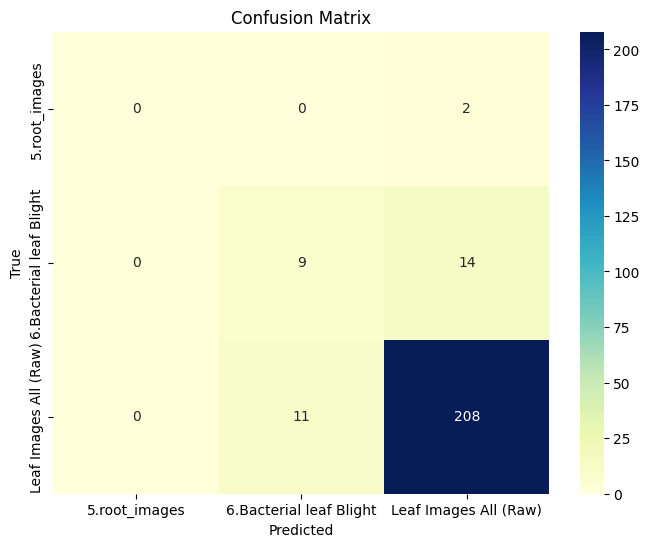

In [19]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()